# Assignment L08: Wine Classification with a MLP

**Author: Preston Went**  
**Course: DATASCI 420**  
**DATE (MM/DD/YYYY): 03/09/2021**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Importing-and-Preparing-the-Data" data-toc-modified-id="Importing-and-Preparing-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing and Preparing the Data</a></span></li><li><span><a href="#Constructing-the-MLP" data-toc-modified-id="Constructing-the-MLP-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Constructing the MLP</a></span><ul class="toc-item"><li><span><a href="#The-Activation-Function" data-toc-modified-id="The-Activation-Function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The Activation Function</a></span></li><li><span><a href="#The-MLP" data-toc-modified-id="The-MLP-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The MLP</a></span></li></ul></li><li><span><a href="#Training-the-MLP" data-toc-modified-id="Training-the-MLP-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training the MLP</a></span><ul class="toc-item"><li><span><a href="#Forward-Propagation" data-toc-modified-id="Forward-Propagation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Forward Propagation</a></span></li><li><span><a href="#Backward-Propagation" data-toc-modified-id="Backward-Propagation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Backward Propagation</a></span></li><li><span><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Gradient Descent</a></span></li></ul></li><li><span><a href="#Evaluating-the-Model" data-toc-modified-id="Evaluating-the-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evaluating the Model</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Introduction

In this assignment, I will be constructing and training a multilayer perceptron (MLP) to classify red and white wine.

Before starting, I will import the necessary libraries. This will be a small list, since I will be defining the activation function, training loop, and backpropagation myself.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set();

# Model evaluation
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# Set our random seed
RAND_SEED = 5743829
np.random.seed(RAND_SEED)

## Importing and Preparing the Data

Now we can import our data. Each row of the data represents a wine, with features as provided in the following table.

|              Feature | Type                  |
|---------------------:|:----------------------|
|        fixed acidity | numeric               |
|     volatile acidity | numeric               |
|          citric acid | numeric               |
|       residual sugar | numeric               |
|            chlorides | numeric               |
|  free sulfur dioxide | numeric               |
| total sulfur dioxide | numeric               |
|              density | numeric               |
|                   pH | numeric               |
|            sulphates | numeric               |
|              alcohol | numeric               |
|                Class | nominal: R = 1, W = 0 |

**(Note: The given RedWhiteWine.csv file is expected to be in the Data/ directory. This notebook will not run otherwise.)**

In [2]:
# Import the data
wine_df = pd.read_csv('Data/RedWhiteWine.csv')

We should split this into testing and training sets now.

In [3]:
# Split the data into a feature matrix and label vector
y = wine_df['Class']
X = wine_df.drop(columns=['Class'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=RAND_SEED)

And, finally, we will normalize each of them so that they fit the range expected by the perceptron.

In [4]:
# Scale our inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Constructing the MLP

Let us build and train the model. We will be using a simple multilayer perceptron, built from scratch.

### The Activation Function

We will use a very simple activation function: the sigmoid, or logistic function. It is not the best, but it works, and is very easy to define.

In [5]:
# Define our sigmoid activation function
def sigmoid(x):
    '''
    A simple, numerically stable sigmoid function.
    :param x: A numpy array containing the values to evaluate.
    :return: The sigmoid of those values, with some caveats.
    '''
    x = np.clip(x, -500, 500) # Clipping to improve numeric stability
    x = np.array(x, dtype=float)
    # Return the sigmoid of x, with a stable case for all negative values
    if x.any()>=0:
        return 1/(1 + np.exp(-x))
    else:
        return np.exp(x)/(1 + np.exp(x))

### The MLP

I will define a MLP as a set of weights and biases, where each weight is between a node in an earlier layer and one in a later layer, and each node has its own bias.

In [6]:
# Define functions for building a MLP

def init_mlp_weights(input_size, layer_sizes):
    '''
    Initializes the weights for an MLP to random values.
    :param input_size: An int giving the number of inputs.
    :param layer sizes: A list giving the number of nodes in each layer.
    :return: An array of arrays of random values. Each subarray is a layer, with
        each element the weights to a node.
    '''
    mlp_weights = []
    for layer_num, layer_size in enumerate(layer_sizes):
        layer_weights = []
        for i in range(layer_size):
            if layer_num == 0: layer_weights.append(np.random.random_sample(input_size).T)
            else: layer_weights.append(np.random.random_sample(layer_sizes[layer_num-1]).T)
        layer_weights = np.array(layer_weights, dtype=object)
        mlp_weights.append(layer_weights)
    mlp_weights = np.array(mlp_weights, dtype=object)
    return mlp_weights

def init_mlp_biases(layer_sizes):
    '''
    Initializes the biases for an MLP to random values.
    :param layer sizes: A list giving the number of nodes in each layer.
    :return: An array of arrays of random values. Each subarray is a layer, with
        each element the bias of a node.
    '''
    mlp_biases = []
    for layer_num, layer_size in enumerate(layer_sizes):
        layer_biases = np.random.random_sample(layer_size).reshape(-1,1)
        mlp_biases.append(layer_biases)
    mlp_biases = np.array(mlp_biases, dtype=object)
    return mlp_biases

def init_mlp(input_size, layer_sizes):
    '''
    Initializes the weights for an MLP to random values.
    :param input_size: An int giving the number of inputs.
    :param layer sizes: A list giving the number of nodes in each layer.
    :return: A dict with weights and biases, each formatted as above.
    '''
    mlp = {'Weights': init_mlp_weights(input_size, layer_sizes),
           'Biases': init_mlp_biases(layer_sizes)}
    return mlp

I will use a MLP with two hidden layers, both with 5 nodes.

In [7]:
# Initialize the MLP
mlp_mdl = init_mlp(input_size=np.shape(X_train)[1], layer_sizes=[5, 5, 1])

## Training the MLP

Now that we have an MLP, we need to train it. Training an MLP has two steps - forward propagation and back propagation - each of which are repeated many times during gradient descent.

### Forward Propagation

Let us start by defining forward propagation. This is where the MLP makes a guess at the classification given the input.

In [8]:
# Define our forward propagation step
def fwd_prop(mlp, X):
    '''
    Propagate inputs forward through the perceptron.
    :param mlp: The perceptron to propagate through.
    :param X: The data to propagate.
    :return: An array of probabilities for the positive case.
    '''
    est = [X.T]
    for layer_num in range(len(mlp['Weights'])):
        layer_weights = mlp['Weights'][layer_num]
        layer_biases = mlp['Biases'][layer_num]
        est.append(sigmoid(np.dot(layer_weights, est[layer_num]) + layer_biases))
    est = np.array(est, dtype=object)
    return est

### Backward Propagation

Next up is backward propagation, where the model's weights are updated based upon its performance in forward propagation. I will use the cross entropy loss here.

In [9]:
def back_prop(mlp, est, X, y):
    '''
    Performs a single back propagation step.
    :param mlp: The multilayer perceptron to act on.
    :param est: Estimations at each node of the given multilayer perceptron.
    :param X: The feature matrix to update with.
    :param y: The label vector corresponding to that feature matrix.
    :return: A tuple containing the cross entropy loss, weight changes, and
        bias changes.
    '''
    m = np.shape(X)[0] # Get the number of inputs
    ce_loss = (-1/m)*np.sum(y*np.log(est[-1]) + (1-y)*np.log(1-est[-1])) # The loss
    
    weight_changes = []
    bias_changes = []
    error = est[-1] - y
    for i in range(len(mlp['Weights'])):
        layer_num = len(mlp['Weights']) - i - 1
        layer_weights = mlp['Weights'][layer_num]
        layer_biases = mlp['Biases'][layer_num]
        
        # Calculate changes in weights and biases
        if layer_num == len(mlp['Weights']) - 1: weight_change = (1/m)*np.dot(error, y)
        else: weight_change = (1/m)*np.dot(error, est[layer_num].T)
        bias_change = (1/m)*np.sum(error, axis=1, keepdims=True)
        
        # Propagate error backward using the derivative of the sigmoid
        if layer_num > 1:
            error = np.multiply(np.dot(mlp['Weights'][layer_num].T, error),
                                sigmoid(est[layer_num-1])*(1-sigmoid(est[layer_num-1])))
        
        weight_changes.append(weight_change)
        bias_changes.append(bias_change)
    weight_changes = np.array(weight_changes[::-1], dtype=object)
    bias_changes = np.array(bias_changes[::-1], dtype=object)
    return (ce_loss, weight_changes, bias_changes)

### Gradient Descent

We can now combine our forward propagation and back propagation functions to accomplish gradient descent training of our model. **Note: This may take several minutes to run.**

In [12]:
# Create the gradient descent function.
def run_grad_desc(mlp, num_epochs, learn_rate, X_train, y_train):
    '''
    Train a multilayer perceptron with back propagation.
    :param mlp: The multilayer perceptron to train.
    :param num_epochs: The number of training iterations.
    :param learn_rate: The learning rate for parameter updates.
    :param X_train: The feature matrix to train on.
    :param y_train: The corresponding label vector.
    :return: A tuple containing the final model and an array of the losses at 
        each step.
    '''
    losses = []
    for i in range(num_epochs):
        est = fwd_prop(mlp, X_train)
        loss, weight_changes, bias_changes = back_prop(mlp, est, X_train, y_train)
        losses.append(loss)
        mlp['Weights'] = mlp['Weights'] - learn_rate*weight_changes
        mlp['Biases'] = mlp['Biases'] - learn_rate*bias_changes
    return (mlp, losses)

In [13]:
# Train the multilayer perceptron with gradient descent
curr_mlp, losses = run_grad_desc(mlp_mdl, 4000, 0.01, X_train, np.array(y_train))

Let us examine the losses to see how training went.

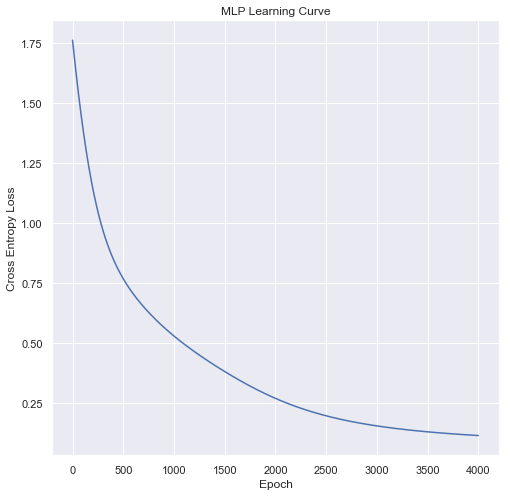

In [15]:
sns.set_style('darkgrid') # Set the plot style
ax = plt.figure(figsize=[8, 8]).gca() # Create the axes

# Plot the learning curve
ax.plot(losses)
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross Entropy Loss')
ax.set_title('MLP Learning Curve');

We achieved a substantial improvement. It appears that we could extend training further to do even better; the tail of the curve is only just starting to flatten out.

## Evaluating the Model

Now that we have trained the model, let us see how well it estimates wine type on our testing data. I will use the classification matrix, AUC-ROC, and average precision as metrics.

In [24]:
final_est = fwd_prop(curr_mlp, X_test) # Get final estimates of the model on the test data
y_pred_proba = final_est[-1][0] # Get the probabilities of the positive class
y_pred = [1 if pos else 0 for pos in (y_pred_proba > 0.5)]

# Get and print performance metrics
print('Avg. Precision: {:.2f}'.format(average_precision_score(y_test, y_pred_proba)))
print('AUC-ROC: {:.2f}'.format(roc_auc_score(y_test, y_pred_proba)))
print(classification_report(y_test, y_pred))

Avg. Precision: 0.99
AUC-ROC: 1.00
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1225
           1       0.92      1.00      0.95       400

    accuracy                           0.98      1625
   macro avg       0.96      0.98      0.97      1625
weighted avg       0.98      0.98      0.98      1625



The model achieves excellent performance, with near perfect average precision and AUC-ROC scores. There is some room for improvement in precision of the positive case, and the learning curve suggests that the model may be capable of this improvement.

## Conclusion

We successfully constructed and trained a MLP to distinguish between red and white wines, achieving an AUC-ROC of 1.00 and an average precision of 0.99. Further improvement may be possible with more training time.